In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
"""Examples of using pyrender for viewing and offscreen rendering.
"""
import numpy as np
import trimesh

import pyrender

############################# MY CODE
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg as la
import pyvista as pv
import imageio.v3 as iio
from scipy.spatial.transform import Rotation
np.set_printoptions(formatter={"float": "{:10.2f}".format})
import imageio
imageio.plugins.freeimage.download()

img_path = "~/data/middlebury/all/data/ladder1/im0.png"
dispm_path = "~/data/middlebury/all/data/ladder1/disp0.pfm"
f = 1733.68
cam = np.array([[f, 0, 819.72], [0, f, 957.55], [0, 0, 1]])
baseline=221.13
doffs=0

imK = cam

pfm = iio.imread(dispm_path,plugin="PFM-FI").astype(np.float32)


for y in range(pfm.shape[0]):
    for x in range(pfm.shape[1]):
        disp = pfm[y,x]
        if disp != 0:
            Z = baseline * f / (disp + doffs)
        else:
            Z = np.nan
        pfm[y,x] = Z

dm = np.flip(pfm,axis=0).copy()
dm[dm == 0] = np.nan

im = iio.imread(img_path)
im = np.asarray(im)

pts = []
invK = la.inv(cam)
for y in range(dm.shape[0]):
    for x in range(dm.shape[1]):
        dist = dm[y,x]
        pt = dist * (invK @ [x,y,1])
        pts.append(pt)

pts = np.array(pts)
pts_orig = pts
pts_orig_cleaned = np.nan_to_num(pts_orig, 0)

mesh = pyrender.Mesh.from_points(pts_orig_cleaned, colors=np.reshape(im,(-1,3)))
############################ MY CODE

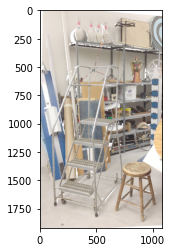

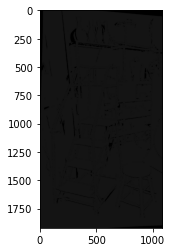

In [21]:
#==============================================================================
# Using the viewer with a pre-specified camera
#==============================================================================
#from scipy.spatial.transform import Rotation
intrinsics = imK
cx = intrinsics[0, 2]
cy = intrinsics[1, 2]
fx = intrinsics[0, 0]
fy = intrinsics[1, 1]
f = fx
cam = pyrender.IntrinsicsCamera(fx = f, fy =f, cx=cx, cy=cy,znear=10, zfar=10000000.0)
cam_orig = cam
rote = [180,0,0.0]
r = Rotation.from_euler("xyz",rote, degrees=True).as_matrix()
t = np.array([[0,0,0]]).T
pose = np.hstack((r,t))
pose = np.vstack((pose,[0,0,0,1]))
#
#print(cam_pose_orig)
#print(pose)

#==============================================================================
l = 1.0
scene = pyrender.Scene(ambient_light=np.array([l, l, l, l]))
#cam_node = scene.add(cam_orig, pose=cam_pose_orig)
cam_node = scene.add(cam_orig, pose=pose)


#==============================================================================
# Rendering offscreen from that camera
#==============================================================================

meshnode = scene.add(mesh)
#v = Viewer(scene, central_node=drill_node)
s = 3
r = pyrender.OffscreenRenderer(viewport_width=dm.shape[1], viewport_height=dm.shape[0])
color, depth = r.render(scene)
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(color)
plt.show()

#==============================================================================
# Segmask rendering
#==============================================================================

nm = {node: 20*(i + 1) for i, node in enumerate(scene.mesh_nodes)}
seg = r.render(scene, pyrender.RenderFlags.SEG, nm)[0]
plt.figure()
plt.imshow(seg)
plt.show()

r.delete()

In [22]:
v = pyrender.Viewer(scene, run_in_thread=True)

while v.is_active:
    pass

from scipy.spatial.transform import Rotation
cx = v._camera_node.rotation

def pyrender_get_pinhole(v: pyrender.Viewer):
    cn : pyrender.Node = v._camera_node
    
    rot_quat = cn.rotation
    rot_mat = Rotation.from_quat(rot_quat).as_matrix()
    rote = [-180,0,0.0]
    r_corr = Rotation.from_euler("xyz",rote, degrees=True).as_matrix()
    rot_mat = rot_mat @ r_corr
    trans = np.array([cn.translation]).T
    pose = np.hstack((rot_mat, trans))
    print(pose)

    return pose

pyrender_get_pinhole(v)

[[      1.00       0.00       0.00       0.00]
 [      0.00       1.00      -0.00       0.00]
 [      0.00       0.00       1.00       0.00]]


array([[      1.00,       0.00,       0.00,       0.00],
       [      0.00,       1.00,      -0.00,       0.00],
       [      0.00,       0.00,       1.00,       0.00]])

[[      1.00       0.00       0.00       0.00]
 [      0.00       1.00      -0.00       0.00]
 [      0.00       0.00       1.00       0.00]]
[[      1.00       0.00       0.00]
 [      0.00      -1.00      -0.00]
 [      0.00       0.00      -1.00]]
[[      0.00]
 [      0.00]
 [      0.00]]


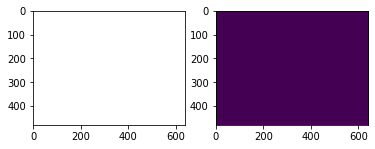

In [24]:
from src.dmcpworkflow.h_backproject_mesh import get_interactive_camera

K, pose, shape = get_interactive_camera(mesh,imK,znear=1,zfar=1000000.0)

from src.dmcpworkflow.h_backproject_mesh import capture_scene
img, depth = capture_scene(mesh, imK, pose[:3,:3], pose[:3,-1], shape[1], shape[0])
plt.figure()
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(depth)
plt.show()

### Reconstruct points from depth map to validate result

In [24]:
dmpts = []
for y in range(depth.shape[0]):
    for x in range(depth.shape[1]):
        dmpts.append([x, y])
dmpts = np.array(dmpts)
dmpts

array([[   0,    0],
       [   1,    0],
       [   2,    0],
       ...,
       [1917, 1010],
       [1918, 1010],
       [1919, 1010]])

In [25]:
from src.pycv.dmcp import dm_to_world

extr = la.inv(np.vstack((pose,[0,0,0,1])))[:3,:]
dmP = K @ extr


wp_dm = dm_to_world(depth, K,dmP,dmpts)

In [26]:
import pyvista as pv
mesh_orig = pv.PolyData(pts_orig_cleaned)
mesh_orig['colors'] = np.reshape(im,(-1,3))

mesh_dm = pv.PolyData(wp_dm)

plotter = pv.Plotter(notebook=False)

plotter.add_mesh(mesh_orig,scalars="colors",rgb=True,point_size=1)
plotter.add_mesh(mesh_dm,color="blue")
plotter.show()
